In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../..")))

from scipy.ndimage import distance_transform_edt

In [13]:
data = {
    "train": {
        "images": [],
        "ground_truth": [],
        "predicted_mask": []
    },
    "validation": {
        "images": [],
        "ground_truth": [],
        "predicted_mask": []
    },
    "test": {
        "images": [],
        "ground_truth": [],
        "predicted_mask": []
    }
}

# Open the image file
base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_unet/")) # SCLabels_prediction_by_set_attention_unet

# base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_attention_unet/"))

# base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_duck_net_256x256/"))

# base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_deeplab/"))

# base_path = os.path.abspath(os.path.join(os.getcwd(), "../../data/SCLabels_prediction_by_set_bilstm/"))

# data_dirs = ["images", "mask", "predicted_mask"]
sub_dirs = ["train", "validation", "test"]

for sub_dir in sub_dirs:
    for file in os.listdir(os.path.join(base_path, "images", sub_dir)):
        if file.endswith(".jpg"):
            path = os.path.join(base_path, "images", sub_dir, file)
            data[sub_dir]["images"].append(path)

            file = file.replace("image.jpg", "mask.png")
            path = os.path.join(base_path, "masks", sub_dir, file)
            data[sub_dir]["ground_truth"].append(path)

            file = file.replace("mask.png", "pred.png")
            path = os.path.join(base_path, "predicted_mask", sub_dir, file)
            data[sub_dir]["predicted_mask"].append(path)

print("Data loaded")

Data loaded


In [59]:
def transform_to_binary(mask, value):
    mask = np.where(mask == value, 1, 0).astype(np.uint8)
    return mask

def chamfer_distance(pred, ground_truth):
    dist_transform = distance_transform_edt(1 - ground_truth)
    distances = dist_transform[pred > 0]
    mean_distance = np.mean(distances)

    return mean_distance

def find_shoreline(pred, land_pixel, sea_pixel):
    shoreline = np.zeros_like(pred)
    for i in range(pred.shape[0]):
        for j in range(1, pred.shape[1]):
            if pred[i, j] == land_pixel and pred[i, j-1] == sea_pixel:
                shoreline[i, j] = 1
            if pred[i, j] == sea_pixel and pred[i, j-1] == land_pixel:
                shoreline[i, j-1] = 1

    for j in range(pred.shape[1]):
        for i in range(1, pred.shape[0]):
            if pred[i, j] == land_pixel and pred[i-1, j] == sea_pixel:
                shoreline[i, j] = 1
            if pred[i, j] == sea_pixel and pred[i-1, j] == land_pixel:
                shoreline[i-1, j] = 1
            
    return shoreline

def find_largest_contour(shoreline_mask):
    # Trobar els contorns a la màscara de la línia de costa
    contours, _ = cv2.findContours(shoreline_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None

    # Trobar el contorn més gran
    largest_contour = max(contours, key=len)

    return largest_contour

def transform_mask_to_shoreline2(pred_path, no_data=0, landward=75, seaward=150):
    pred = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)

    shoreline = find_shoreline(pred, landward, seaward)

    largest_contour = find_largest_contour(shoreline)

    if largest_contour is None:
        return None 

    # Crear una màscara per dibuixar el contorn més gran
    largest_shoreline = np.zeros_like(shoreline)
    cv2.drawContours(largest_shoreline, [largest_contour], -1, 1, thickness=cv2.FILLED)

    return largest_shoreline, shoreline

    # return shoreline

Image:  c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\SCLabels_prediction_by_set_unet\images\test\1534682924.Sun.Aug.19_13_48_44.CET.2018.cies.image.jpg
Ground Truth:  c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\SCLabels_prediction_by_set_unet\masks\test\1534682924.Sun.Aug.19_13_48_44.CET.2018.cies.mask.png
Predicted Mask:  c:\Users\josep\Documents\SOCIB\Shoreline-extraction\data\SCLabels_prediction_by_set_unet\predicted_mask\test\1534682924.Sun.Aug.19_13_48_44.CET.2018.cies.pred.png


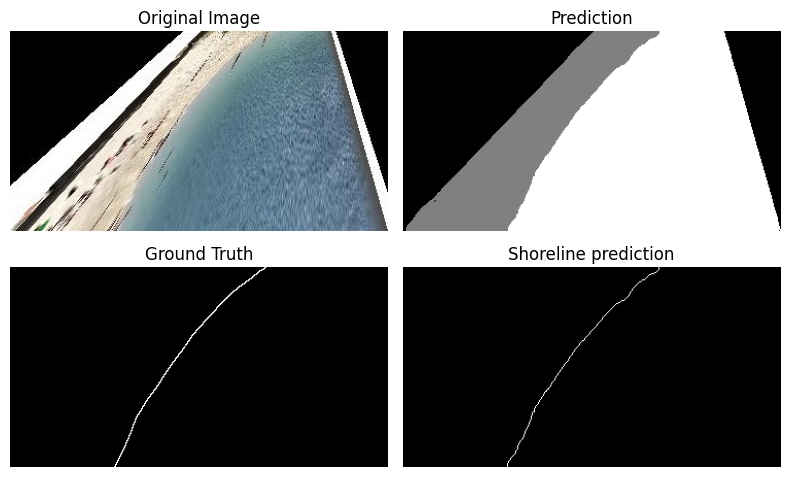

In [129]:
index = 3 # 85 # 160 # 102
img = data["test"]["images"][index]
ground_truth_path = data["test"]["ground_truth"][index]
pred_path = data["test"]["predicted_mask"][index]

print("Image: ", img)
print("Ground Truth: ", ground_truth_path)
print("Predicted Mask: ", pred_path)

img = cv2.imread(img)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
if "bilstm" in base_path:
    ground_truth = transform_mask_to_shoreline2(pred_path = ground_truth_path, landward=1, seaward=0)
else:
    ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
    ground_truth = transform_to_binary(ground_truth, 255) # depends on the prediction, the new ones are 3


# pred = transform_mask_to_shoreline2(pred_path = pred_path, landward=1, seaward=2)
pred, _ = transform_mask_to_shoreline2(pred_path = pred_path, landward=75, seaward=150)

fig, axes = plt.subplots(2, 2, figsize=(8, 5))

# Mostra cada imatge en un subplot
axes[0][0].imshow(img)
axes[0][0].set_title("Original Image")
axes[0][0].axis("off")

pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
axes[0][1].imshow(pred_mask, cmap="gray")
axes[0][1].set_title("Prediction")
axes[0][1].axis("off")

axes[1][0].imshow(ground_truth, cmap="gray")
axes[1][0].set_title("Ground Truth")
axes[1][0].axis("off")

axes[1][1].imshow(pred, cmap="gray")
axes[1][1].set_title("Shoreline prediction")
axes[1][1].axis("off")

plt.tight_layout()
plt.show()


In [61]:
def compute_chamfer_distance(data_set):

    coasts = ["agrelo", "cies", "cadiz", "samarador", "arenaldentem", "global"]
    global_distance = {
        "agrelo": [],
        "cies": [],
        "cadiz": [],
        "samarador": [],
        "arenaldentem": [],
        "global": []
    }

    min_distance = 1000
    min_img = ""
    min_index = 0

    for index in range(len(data_set["images"])):
        # print(data_set["images"][index])
        img_path = data_set["images"][index]
        ground_truth_path = data_set["ground_truth"][index]
        pred_path = data_set["predicted_mask"][index]

        # img = cv2.imread(img_path)
        if "bilstm" in base_path:
            ground_truth = transform_mask_to_shoreline2(pred_path = ground_truth_path, landward=1, seaward=0)
        else:
            ground_truth = cv2.imread(ground_truth_path, cv2.IMREAD_GRAYSCALE)
            ground_truth = transform_to_binary(ground_truth, 3)

        landward = 1
        seaward = 0 if "bilstm" in base_path else 2
        # print("Landward: ", landward, " Seaward: ", seaward)
        pred = transform_mask_to_shoreline2(pred_path, landward=landward, seaward=seaward)

        if pred is None:
            print("No prediction found for ", pred_path)
            continue

        distance = chamfer_distance(pred, ground_truth)

        for coast in coasts:
            if coast in img_path:
                global_distance[coast].append(distance)
        
        global_distance["global"].append(distance)

        if distance < min_distance:
            min_distance = distance
            min_img = img_path
            min_index = index

        # distance = chamfer_distance(pred, ground_truth)
        # global_distance.append(distance)
        # print(index, distance, data_set["images"][index])
    
    # print("Mean distance: ", np.mean(global_distance))
    # print("Std distance: ", np.std(global_distance))
    # print("Max distance: ", np.max(global_distance))
    # print("Min distance: ", np.min(global_distance))

    for coast in coasts:
        print(f"\n{coast} - {len(global_distance[coast])} images")
        print("Mean distance: ", np.mean(global_distance[coast]))
        print("Std distance: ", np.std(global_distance[coast]))
        print("Max distance: ", np.max(global_distance[coast]))
        print("Min distance: ", np.min(global_distance[coast]))

    print(min_distance, min_img, min_index)

In [6]:
print("Train set")
compute_chamfer_distance(data["train"])

Train set

agrelo - 170 images
Mean distance:  28.577198818435424
Std distance:  58.57988716423532
Max distance:  339.40567178403035
Min distance:  1.362986403128434

cies - 301 images
Mean distance:  10.626540645326894
Std distance:  14.844252036794202
Max distance:  87.77500346348606
Min distance:  0.5812093925274938

cadiz - 662 images
Mean distance:  27.676261376429423
Std distance:  19.354581571988756
Max distance:  149.20079397881344
Min distance:  1.9951843090072965

samarador - 39 images
Mean distance:  14.947233461385432
Std distance:  10.945394371338452
Max distance:  41.402117466216026
Min distance:  2.4437696107322195

arenaldentem - 28 images
Mean distance:  44.21066119173562
Std distance:  99.81582500857532
Max distance:  411.6390034141044
Min distance:  1.4010523095537777

global - 1200 images
Mean distance:  23.499365152446938
Std distance:  32.42941172241015
Max distance:  411.6390034141044
Min distance:  0.5812093925274938
0.5812093925274938 c:\Users\josep\Documents\S

In [7]:
print("\nValidation set")
compute_chamfer_distance(data["validation"])


Validation set

agrelo - 49 images
Mean distance:  39.21070594663585
Std distance:  76.25382173522355
Max distance:  325.3224372402183
Min distance:  1.8577061730566902

cies - 85 images
Mean distance:  10.08743118502195
Std distance:  13.161798948721946
Max distance:  65.69918073238597
Min distance:  0.578365653689452

cadiz - 189 images
Mean distance:  25.85033314256718
Std distance:  19.258878952462396
Max distance:  100.0527191921372
Min distance:  4.26929213732651

samarador - 12 images
Mean distance:  15.334087824658967
Std distance:  9.98998863742366
Max distance:  44.96899991553603
Min distance:  5.657945061443317

arenaldentem - 8 images
Mean distance:  20.447258719197308
Std distance:  24.99281904345191
Max distance:  83.6144512225669
Min distance:  2.716385321650039

global - 343 images
Mean distance:  23.35876480964054
Std distance:  34.372159830195365
Max distance:  325.3224372402183
Min distance:  0.578365653689452
0.578365653689452 c:\Users\josep\Documents\SOCIB\Shoreli

In [8]:
print("\nTest set")
compute_chamfer_distance(data["test"])


Test set

agrelo - 25 images
Mean distance:  28.66800196394114
Std distance:  39.80184395302538
Max distance:  205.14030181520434
Min distance:  1.4086225765298306

cies - 44 images
Mean distance:  12.99444884218674
Std distance:  16.998459655434676
Max distance:  66.12810990532819
Min distance:  1.2022663118515435

cadiz - 95 images
Mean distance:  27.449911173800103
Std distance:  18.524946702072537
Max distance:  83.74285563759193
Min distance:  3.1492598565160534

samarador - 6 images
Mean distance:  21.511802514419728
Std distance:  30.13217283194391
Max distance:  88.38533250039458
Min distance:  5.695347907677357

arenaldentem - 4 images
Mean distance:  40.528545880779504
Std distance:  39.67098161209033
Max distance:  108.58854224147794
Min distance:  12.413451903272241

global - 174 images
Mean distance:  24.06541585215742
Std distance:  24.541388913481786
Max distance:  205.14030181520434
Min distance:  1.2022663118515435
1.2022663118515435 c:\Users\josep\Documents\SOCIB\Sho

# Figures

In [125]:
CLASS_COLORS = {
    'NoData': (0, 0, 0),        # (black)
    'Landwards': (139, 69, 19), # (brown)
    'Seawards': (0, 0, 255),    # (blue)
    'Shoreline': (0, 255, 0)    # (green)
}

# Define a custom colormap for the mask
def apply_custom_colormap(mask):
    # Create an RGB image initialized to black
    colored_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)

    # Assign colors based on class values
    colored_mask[mask == 0] = CLASS_COLORS["NoData"]
    colored_mask[mask == 150] = CLASS_COLORS["Seawards"]
    colored_mask[mask == 75] = CLASS_COLORS["Landwards"]
    colored_mask[mask == 255] = CLASS_COLORS["Shoreline"]

    return colored_mask

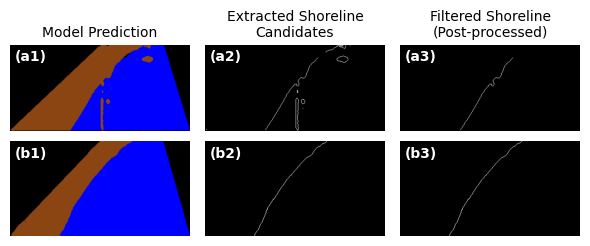

In [126]:
index = 4 # 85 # 160 # 102
img = data["test"]["images"][index]
ground_truth_path = data["test"]["ground_truth"][index]
pred_path = data["test"]["predicted_mask"][index]

# pred = transform_mask_to_shoreline2(pred_path = pred_path, landward=1, seaward=2)
pred_transformed, all_shorelines = transform_mask_to_shoreline2(pred_path = pred_path, landward=75, seaward=150)

fig, axes = plt.subplots(2, 3, figsize=(12/2, 2.6))  # Slightly wider

crop_size = (300, 180)
pred = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
# mask_crop = crop_center(pred, crop_size, config['cies']['start'])

# Apply color to mask
colored_mask = apply_custom_colormap(pred)


# Mostra cada imatge en un subplot
axes[0][0].imshow(colored_mask)
axes[0][0].set_title("\nModel Prediction", fontsize=10)
axes[0][0].axis("off")
axes[0, 0].text(10, 35, "(a1)", fontsize=10, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

# all_shorelines = crop_center(all_shorelines, crop_size, config['cies']['start'])
axes[0][1].set_title("Extracted Shoreline\nCandidates", fontsize=10)
axes[0][1].axis("off")
axes[0][1].imshow(all_shorelines, cmap="gray")
axes[0, 1].text(10, 35, "(a2)", fontsize=10, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

# pred_transformed = crop_center(pred_transformed, crop_size, config['cies']['start'])
axes[0][2].imshow(pred_transformed, cmap="gray")
axes[0][2].set_title("Filtered Shoreline\n(Post-processed)", fontsize=10)
axes[0][2].axis("off")
axes[0, 2].text(10, 35, "(a3)", fontsize=10, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

# ------------------------------

index = 3 # 85 # 160 # 102
img = data["test"]["images"][index]
ground_truth_path = data["test"]["ground_truth"][index]
pred_path = data["test"]["predicted_mask"][index]

# pred = transform_mask_to_shoreline2(pred_path = pred_path, landward=1, seaward=2)
pred_transformed, all_shorelines = transform_mask_to_shoreline2(pred_path = pred_path, landward=75, seaward=150)

# crop_size = (300, 300)
pred = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
# mask_crop = crop_center(pred, crop_size, config['cies']['start'])

# Apply color to mask
colored_mask = apply_custom_colormap(pred)

# Mostra cada imatge en un subplot
axes[1][0].imshow(colored_mask)
# axes[1][0].set_title("Prediction")
axes[1][0].axis("off")
axes[1, 0].text(10, 35, "(b1)", fontsize=10, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

# all_shorelines = crop_center(all_shorelines, crop_size, config['cies']['start'])
# axes[1][1].set_title("All shorelines")
axes[1][1].axis("off")
axes[1][1].imshow(all_shorelines, cmap="gray")
axes[1, 1].text(10, 35, "(b2)", fontsize=10, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

# pred_transformed = crop_center(pred_transformed, crop_size, config['cies']['start'])
axes[1][2].imshow(pred_transformed, cmap="gray")
# axes[1][2].set_title("Final shoreline")
axes[1][2].axis("off")
axes[1, 2].text(10, 35, "(b3)", fontsize=10, color='white', weight='bold', bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

plt.tight_layout()
plt.show()
